In [4]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import subprocess
from pydub.utils import mediainfo
from google.cloud import speech
from google.cloud import storage
import srt
import datetime
from google.cloud.video.transcoder_v1.services.transcoder_service import (
    TranscoderServiceClient,
)

In [18]:
def audio_info(audio_filepath):
  

    audio_data = mediainfo(audio_filepath)
    print(audio_data)
    channels = audio_data["channels"]
    bit_rate = audio_data["bit_rate"]
    sample_rate = audio_data["sample_rate"]

    return channels, bit_rate, sample_rate


In [12]:
def subtitle_generation(response, bin_size=3):
    """We define a bin of time period to display the words in sync with audio. 
    Here, bin_size = 3 means each bin is of 3 secs. 
    All the words in the interval of 3 secs in result will be grouped togather."""
    transcriptions = []
    index = 0
 
    for result in response.results:
        try:
            print("-" * 20)
            print("First alternative of result {}".format(i))
            print(u"Transcript: {}".format(alternative.transcript))
            print(u"First Word and Confidence: ({}, {})".format(alternative.words[0].word, alternative.words[0].confidence))
            if result.alternatives[0].words[0].start_time.seconds:
                # bin start -> for first word of result
                start_sec = result.alternatives[0].words[0].start_time.seconds 
                start_microsec = result.alternatives[0].words[0].start_time.microseconds
            else:
                # bin start -> For First word of response
                start_sec = 0
                start_microsec = 0 
            end_sec = start_sec + bin_size # bin end sec
            
            # for last word of result
            last_word_end_sec = result.alternatives[0].words[-1].end_time.seconds
            last_word_end_microsec = result.alternatives[0].words[-1].end_time.microseconds
            
            # bin transcript
            transcript = result.alternatives[0].words[0].word
            
            index += 1 # subtitle index

            for i in range(len(result.alternatives[0].words) - 1):
                try:
                    word = result.alternatives[0].words[i + 1].word
                    word_start_sec = result.alternatives[0].words[i + 1].start_time.seconds
                    word_start_microsec = result.alternatives[0].words[i + 1].start_time.microseconds # 0.001 to convert nana -> micro
                    word_end_sec = result.alternatives[0].words[i + 1].end_time.seconds
                    word_end_microsec = result.alternatives[0].words[i + 1].end_time.microseconds

                    if word_end_sec < end_sec:
                        transcript = transcript + " " + word
                    else:
                        previous_word_end_sec = result.alternatives[0].words[i].end_time.seconds
                        previous_word_end_microsec = result.alternatives[0].words[i].end_time.microseconds                        
                        # append bin transcript
                        transcriptions.append(srt.Subtitle(index, datetime.timedelta(0, start_sec, start_microsec), datetime.timedelta(0, previous_word_end_sec, previous_word_end_microsec), transcript))
                        
                        # reset bin parameters
                        start_sec = word_start_sec
                        start_microsec = word_start_microsec
                        end_sec = start_sec + bin_size
                        transcript = result.alternatives[0].words[i + 1].word
                        
                        index += 1
                except IndexError:
                    pass
            # append transcript of last transcript in bin
            transcriptions.append(srt.Subtitle(index, datetime.timedelta(0, start_sec, start_microsec), datetime.timedelta(0, last_word_end_sec, last_word_end_microsec), transcript))
            index += 1
        except IndexError:
            pass
    
    subtitles = srt.compose(transcriptions)
    return subtitles

In [13]:
import os
files=os.listdir("/content/audio")
print(files)


['mrt_02624_00459867779.wav', 'mrt_04310_01296588961.wav', 'mrt_02436_01118900915.wav', 'mrt_02436_01142336346.wav', 'mrt_03397_01056594829.wav', 'mrt_03397_01906514832.wav', 'mrt_04310_00952396785.wav', 'mrt_04310_00331730744.wav', 'mrt_03398_01675504879.wav', 'mrt_09697_00476676389.wav', 'mrt_04310_00164531172.wav', 'mrt_09697_01834070454.wav', 'mrt_02436_00154358097.wav', 'mrt_03397_00942481581.wav', 'mrt_02624_01916358767.wav', 'mrt_03397_00129434087.wav', 'mrt_02624_01527619254.wav', 'mrt_02436_01552526138.wav', 'mrt_04310_00857386910.wav', 'mrt_02624_00090780723.wav']


In [36]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/sonic-totem-371500-b3da284aec9e.json"

In [ ]:
import pandas as pd

In [66]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 2.2 MB 55.6 MB/s 


In [70]:
import pandas as pd
df=pd.read_csv('/content/line_index.tsv',sep='\t',header=None)
df.set_index(0)

,1
0,
mrt_01523_01464306257,एक बस चार तासांपूर्वी येऊन गेली आणि पुढची बस य...
mrt_04310_01727087719,अमरापूर गावाला रुपेरी पडद्यावर ओळख निर्माण करू...
mrt_03398_00598923081,आज लंडनमध्ये कमाल तापमान पंचवीस अंश सेल्सिअस अ...
mrt_02624_01527619254,आता ती छत्री कुठे आहे ?
mrt_01523_00829338962,मी तुमच्यासाठी काय करू शकते ?
...,...
mrt_09697_00377607090,आपल्या सुरक्षकवचातून बाहेर पडा
mrt_03397_02018280946,एकोणीसशे बेचाळीसमधे लता अवघ्या तेरा वर्षांची ह...
mrt_03397_01672858913,एखाद्या व्यक्तीला ओवाळताना ती व्यक्ती बसलेल्या...


In [84]:
import os
from jiwer import wer
filesize=[]
time_taken = []
first_word_accuracy=[]
import time
errors=[]

# import required library
from pydub import AudioSegment
client = speech.SpeechClient()
for f in files:
  filesize.append(os.path.getsize("/content/audio/"+f))
  wav_file = AudioSegment.from_file(file="/content/audio/"+f, format="wav")
  with open('/content/audio/'+f, "rb") as audio_file:
    content = audio_file.read()
  audio = speech.RecognitionAudio(content=content)
  config = speech.RecognitionConfig(
    encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
    sample_rate_hertz=wav_file.frame_rate,
    language_code="mr-IN",
    enable_word_confidence=True,)
  t1=time.time()
  response = client.recognize(config=config, audio=audio)
  t2=time.time()
  time_taken.append(t2-t1)
  print("-" * 20)
  print(f)
  print("It took {} seconds to recognize words from the audio file".format(t2-t1))
  for i, result in enumerate(response.results):
    
    alternative = result.alternatives[0]
    first_word_accuracy.append(alternative.words[0].confidence)
    print("First alternative of result {}".format(i))
    print(u"Transcript: {}".format(alternative.transcript))
    print(
        u"First Word and Confidence: ({}, {})".format(
            alternative.words[0].word, alternative.words[0].confidence
        )
    )
    gt=df.loc[df[0] == f[:f.index(".")]]
    temp=gt[1].astype(str)
    temp2=temp.to_string()

    error = wer(temp2, alternative.transcript)


--------------------
mrt_02624_00459867779.wav
It took 0.7511029243469238 seconds to recognize words from the audio file
First alternative of result 0
Transcript: खरंच धन्यवाद
First Word and Confidence: (खरंच, 0.6187698245048523)
--------------------
mrt_04310_01296588961.wav
It took 0.5824134349822998 seconds to recognize words from the audio file
First alternative of result 0
Transcript: काही हरकत नाही मी वाट
First Word and Confidence: (काही, 0.9025092720985413)
--------------------
mrt_02436_01118900915.wav
It took 0.5937609672546387 seconds to recognize words from the audio file
First alternative of result 0
Transcript: कुत्रे खूप छान असतात
First Word and Confidence: (कुत्रे, 0.9025092720985413)
--------------------
mrt_02436_01142336346.wav
It took 0.5827527046203613 seconds to recognize words from the audio file
First alternative of result 0
Transcript: एवढा राग कशामुळे
First Word and Confidence: (एवढा, 0.9025092720985413)
--------------------
mrt_03397_01056594829.wav
It took 0.

In [88]:
print(error)

0.42857142857142855


In [83]:
gt=df.loc[df[0] == 'mrt_02624_00090780723']
temp=gt[1].astype(str)
temp2=temp.to_string()


<class 'str'>


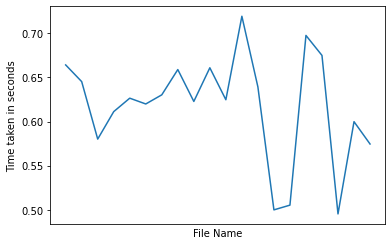

In [58]:
from matplotlib import pyplot as plt

plt.plot(files, time_taken)
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16], 'b-.')
plt.xlabel("File Name")
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.ylabel("Time taken in seconds")
plt.show()

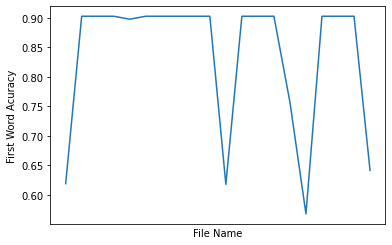

In [59]:
plt.plot(files,first_word_accuracy)
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16], 'b-.')
plt.xlabel("File Name")
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.ylabel("First Word Acuracy")
plt.show()

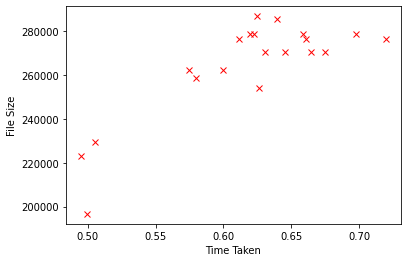

In [65]:
plt.plot(time_taken,filesize,"rx")
time
#plt.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16], 'b-.')
plt.ylabel("File Size")
frame1 = plt.gca()
plt.xlabel("Time Taken")
plt.show()

In [56]:
print(filesize)
print(time_taken)


[270380, 270380, 258622, 276454, 253996, 278572, 270380, 278572, 278572, 276454, 286764, 276454, 285370, 196652, 229420, 278572, 270380, 222956, 262188, 262188]
[0.6641685962677002, 0.6452333927154541, 0.5800848007202148, 0.6112179756164551, 0.6264638900756836, 0.6198856830596924, 0.6302578449249268, 0.6589059829711914, 0.6227586269378662, 0.6609241962432861, 0.6246955394744873, 0.7193574905395508, 0.6392168998718262, 0.4998335838317871, 0.5051898956298828, 0.6976079940795898, 0.6749556064605713, 0.4952428340911865, 0.5998313426971436, 0.5745069980621338]


In [23]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
